In [1]:
from random import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from ast import literal_eval
import os
from scipy.optimize import curve_fit
from scipy import stats
sns.set()

In [2]:
df = pd.read_csv("cvpr_data.csv")

Text(0, 0.5, 'Total Number of Papers')

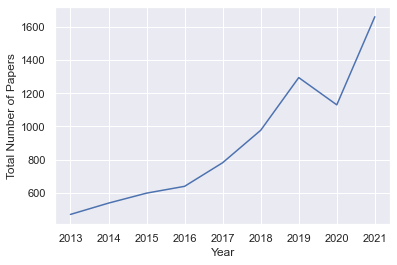

In [3]:
paper_counts = df["year"].value_counts()
plt.figure()
sns.lineplot(x=paper_counts.keys(), y=paper_counts)
plt.xlabel("Year")
plt.ylabel("Total Number of Papers")

In [4]:
# convert citation date to datetime object
def convert_to_datetime(date_array):
    date_array = literal_eval(date_array)
    out = []
    for d in date_array:
        if d is not None:
            out.append(datetime.date(d[0], d[1], d[2]))
        else:
            out.append(None)
    return out

df["citation_date"] = df["citation_date"].apply(convert_to_datetime)

# sort dates and impute missing values randomly
def impute_and_sort_citation(datetime_array):
    N = len(datetime_array)
    # data imputation for missing dates
    for i in range(N):
        if datetime_array[i] == None:
            # pick a random date from the list
            random_date = None
            while random_date is None:
                random_date = datetime_array[np.random.randint(0, N-1)]
            datetime_array[i] = random_date + datetime.timedelta(days=np.random.randint(0, 100))
    
    # sort
    return sorted(datetime_array)

df["citation_date"] = df["citation_date"].apply(impute_and_sort_citation)

In [5]:
def time_delta(sorted_datetime_array):
    N = len(sorted_datetime_array)
    if N > 0:
        time_delta = []
        for i in range(N):
            time_delta.append(sorted_datetime_array[i] - sorted_datetime_array[0])
        return np.array(time_delta)
    else:
        return np.array([datetime.timedelta(0)])

df["time_delta"] = df["citation_date"].apply(time_delta)

def cumulative_citation_count(sorted_datetime_array):
    N = len(sorted_datetime_array)
    return np.arange(1,N+1,1) if N>0 else np.array([0])

df["cumulative_citation_count"] = df["citation_date"].apply(cumulative_citation_count)

df["log_citation_count"] = np.log10(df["citation_count"]+1)

Text(-0.16499999999999915, 0.5, 'Total Number of Papers')

<Figure size 432x288 with 0 Axes>

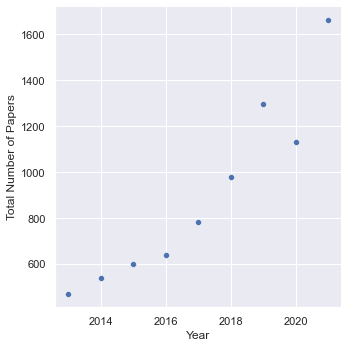

In [6]:
paper_counts = df["year"].value_counts()
plt.figure()
sns.relplot(x=paper_counts.keys(), y=paper_counts)
plt.xlabel("Year")
plt.ylabel("Total Number of Papers")

<AxesSubplot:xlabel='log_citation_count', ylabel='Proportion'>

<Figure size 432x288 with 0 Axes>

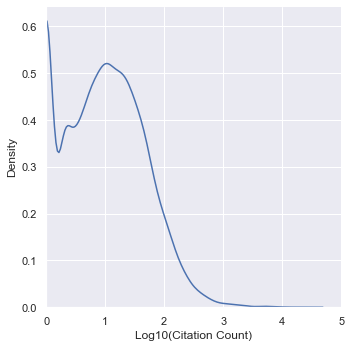

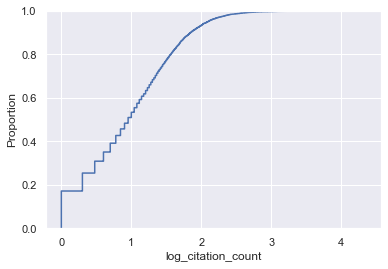

In [7]:
plt.figure()
sns.displot(data=df, x="log_citation_count", kind="kde")
plt.xlabel("Log10(Citation Count)")
plt.xlim(0, 5)

plt.figure()
sns.ecdfplot(data=df, x="log_citation_count" )

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

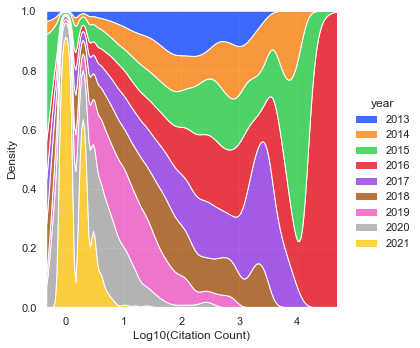

<Figure size 432x288 with 0 Axes>

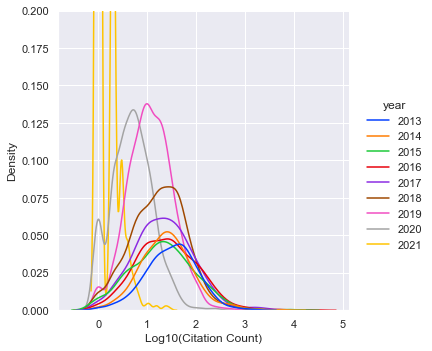

In [8]:
plt.figure()
sns.displot(data=df, x="log_citation_count", hue="year", kind="kde", multiple="fill", palette=sns.color_palette("bright",9))
plt.xlabel("Log10(Citation Count)")

plt.figure()
sns.displot(data=df, x="log_citation_count", hue="year", kind="kde", palette=sns.color_palette("bright",9))
plt.xlabel("Log10(Citation Count)")
plt.ylim(0, 0.2)

In [9]:
df_1000 = df[df["citation_count"] > 1000]
df_1000 = df_1000.sort_values(by="citation_count", ascending=False)
df_1000.head(10)
df_1000 = df_1000[["title", "citation_count", "year", "pdf_link"]]

df_1000["pdf_link"] = df_1000["pdf_link"].apply(lambda x: "https://openaccess.thecvf.com/"+"/".join(x.split("/")[2:]))

df_1000.to_csv("top1000.csv", index=False)

0


c:\Users\ceku\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ceku\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ceku\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ceku\anaconda3\l

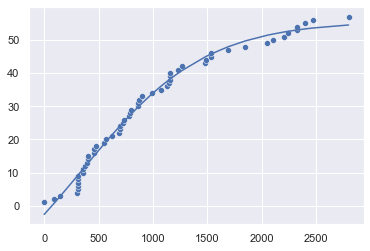

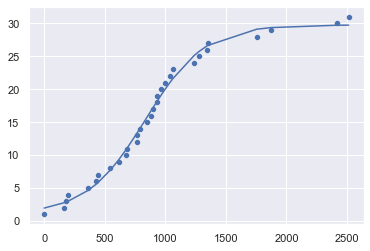

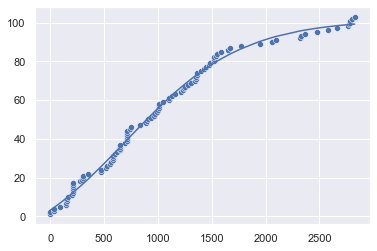

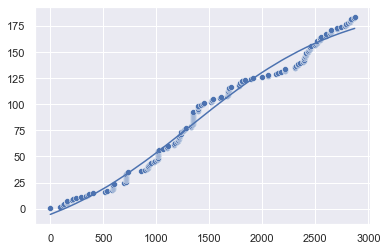

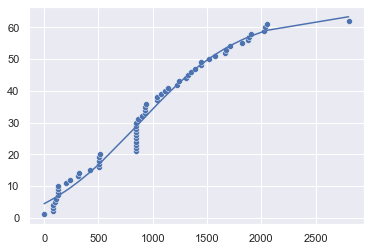

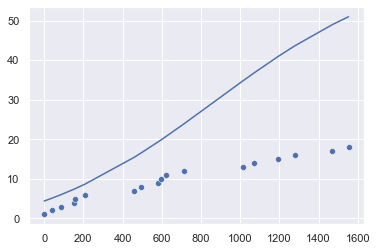

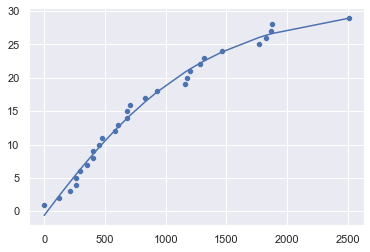

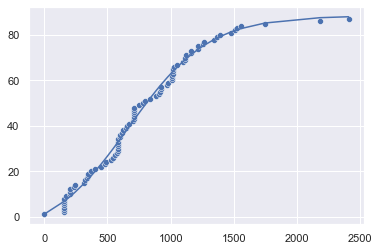

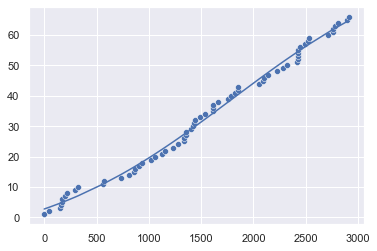

In [10]:
def logistic(t, t0, L, k, b):
    return b + L/(1+np.exp(-k*(t-t0)))

for i in range(10):
    tdata = df.iloc[i,:]["time_delta"]
    if i % 100 == 0: print(i)
    if len(tdata) > 10:
        tdata = np.array([t.days for t in tdata])
        cdata = df.iloc[i,:]["cumulative_citation_count"]
        pguess = [np.median(tdata), cdata.max(), 1./np.mean(np.diff(tdata)), 1. ]
        
        try:
            popt, pcov = curve_fit(f=logistic, xdata=tdata, ydata=cdata, p0=pguess, method='dogbox')
        except:
            pass
        
        y_logistic = logistic(tdata, *popt)
        
        plt.figure()
        sns.scatterplot(tdata, cdata)
        sns.lineplot(tdata, y_logistic)
        # plt.savefig("fits\\df_"+str(i)+".png")
        # plt.close()

0


c:\Users\ceku\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ceku\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ceku\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ceku\anaconda3\l

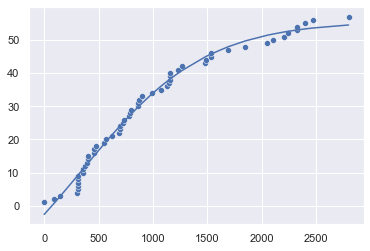

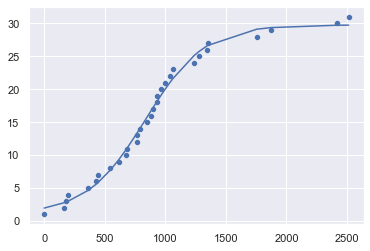

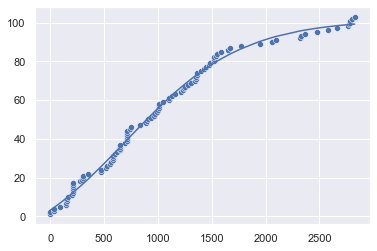

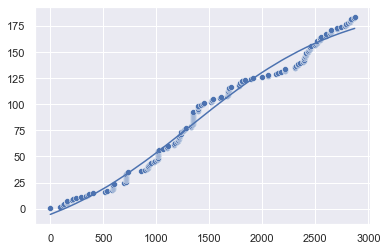

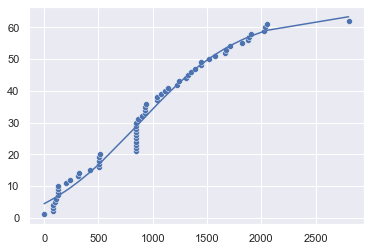

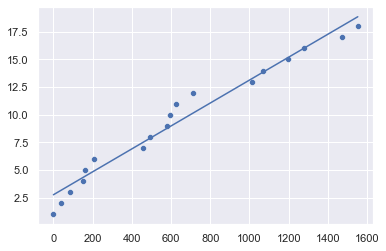

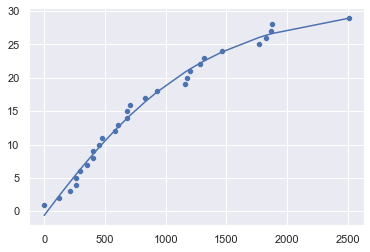

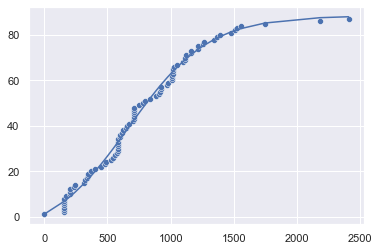

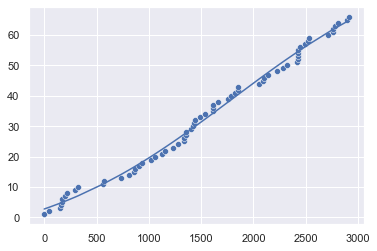

In [11]:
for i in range(10):
    tdata = df.iloc[i,:]["time_delta"]
    if i % 100 == 0: print(i)
    if len(tdata) > 10:
        tdata = np.array([t.days for t in tdata])
        cdata = df.iloc[i,:]["cumulative_citation_count"]
        pguess = [np.median(tdata), cdata.max(), 1./np.mean(np.diff(tdata)), 1. ]
        
        try:
            popt, pcov = curve_fit(f=logistic, xdata=tdata, ydata=cdata, p0=pguess, method='dogbox')
        except:
            pass
        
        res = stats.linregress(tdata, cdata)
        y_linear = res.slope * tdata + res.intercept
        y_logistic = logistic(tdata, *popt)

        mse = lambda x: np.mean((cdata - x)**2)
        if (mse(y_linear) < mse(y_logistic)):
            y_pred = y_linear
        else:
            y_pred = y_logistic
        
        plt.figure()
        sns.scatterplot(tdata, cdata)
        sns.lineplot(tdata, y_pred)
        # plt.savefig("fits\\df_"+str(i)+".png")
        # plt.close()

In [12]:
try:
    os.mkdir("fits")
except:
    print("Fits folder exists")

save_plots = False
fit_params = []
fit_type = []
for i in range(len(df)):
    tdata = df.iloc[i,:]["time_delta"]
    if i % 100 == 0: print(i)
    tdata = np.array([t.days for t in tdata])
    cdata = df.iloc[i,:]["cumulative_citation_count"]
    pguess = [np.median(tdata), cdata.max(), 1./np.mean(np.diff(tdata)), 1. ]
    
    try:
        popt, pcov = curve_fit(f=logistic, xdata=tdata, ydata=cdata, p0=pguess, method='dogbox')
    except:
        pass
    
    res = stats.linregress(tdata, cdata)
    y_linear = res.slope * tdata + res.intercept
    y_logistic = logistic(tdata, *popt)

    mse = lambda x: np.mean((cdata - x)**2)
    if (mse(y_linear) < mse(y_logistic)):
        y_pred = y_linear
        fit_params.append(np.array([res.slope, res.intercept]))
        fit_type.append(0)
    else:
        y_pred = y_logistic
        fit_params.append(popt)
        fit_type.append(1)
    if save_plots:
        plt.figure()
        plt.scatter(tdata, cdata)
        plt.plot(tdata, y_pred)
        plt.savefig("fits\\df_"+str(i)+".png")
        plt.close()
df["fit_type"] = fit_type
df["fit_params"] = fit_params

Fits folder exists
0


c:\Users\ceku\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\ceku\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ceku\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\ceku\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\ceku\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\ceku\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: 

100
200


<ipython-input-10-62de59788255>:3: RuntimeWarning: overflow encountered in exp
  return b + L/(1+np.exp(-k*(t-t0)))


300
400
500
600
700
800
900
1000
1100
1200
1300
1400


<ipython-input-12-fb5d53a5378b>:15: RuntimeWarning: divide by zero encountered in double_scalars
  pguess = [np.median(tdata), cdata.max(), 1./np.mean(np.diff(tdata)), 1. ]
<ipython-input-10-62de59788255>:3: RuntimeWarning: invalid value encountered in multiply
  return b + L/(1+np.exp(-k*(t-t0)))


1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700


c:\Users\ceku\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
c:\Users\ceku\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


7800
7900
8000


In [13]:
logistic_fits = df[df["fit_type"] == 1].fit_params

# t0, L, k, b
logistic_fits = pd.DataFrame(logistic_fits.tolist(), columns=("t", "l", "k", "b"))
logistic_fits["year"] = df[df["fit_type"] == 1].year
logistic_fits = logistic_fits.dropna()
logistic_fits.describe()

,t,l,k,b,year
count,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,434.817707,117.969595,0.060140,-25.573632,2016.881611
std,582.565645,1847.943700,0.168286,439.704260,2.189213
min,-8916.537638,-2.168720,-0.876190,-19947.944075,2013.000000
25%,60.496108,2.259639,0.002967,-4.096402,2015.000000
50%,360.425808,14.300861,0.008264,0.599077,2017.000000
75%,732.084311,50.643433,0.046471,0.996866,2019.000000
max,5036.078590,112258.855508,2.249474,13.749357,2020.000000


c:\Users\ceku\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


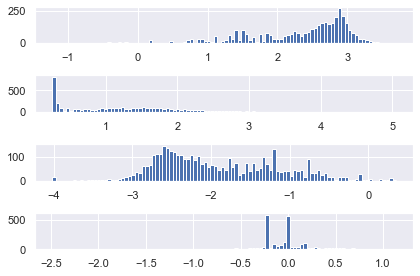

In [14]:
fig, axs = plt.subplots(4,1)
for i in range(4):
    axs[i].hist(np.log10(logistic_fits.iloc[:,i]), bins=100)
plt.tight_layout()

c:\Users\ceku\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ceku\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

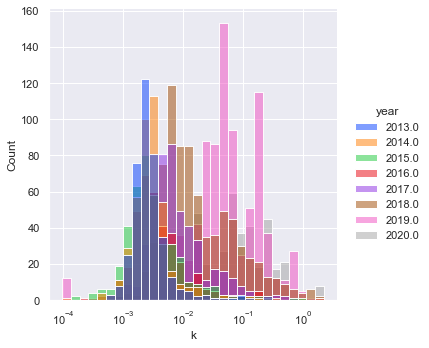

<Figure size 432x288 with 0 Axes>

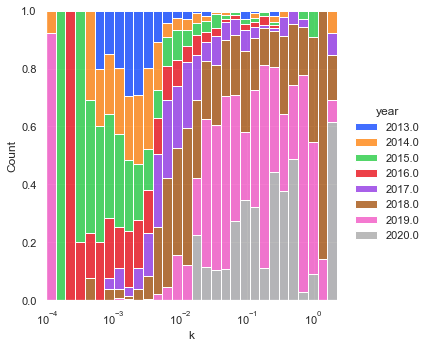

In [15]:
plt.figure()
sns.displot(data=logistic_fits, x="k", hue="year", palette=sns.color_palette("bright", 8), log_scale=True, multiple="layer")
plt.figure()
sns.displot(data=logistic_fits, x="k", hue="year", palette=sns.color_palette("bright", 8), log_scale=True, multiple="fill")

c:\Users\ceku\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ceku\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

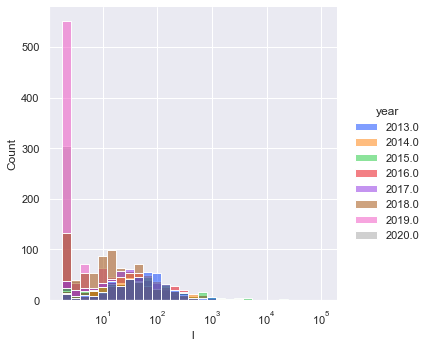

<Figure size 432x288 with 0 Axes>

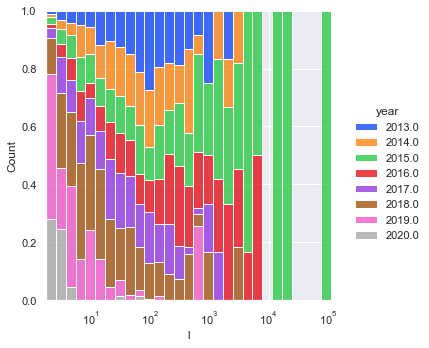

In [16]:
plt.figure()
sns.displot(data=logistic_fits, x="l", hue="year", palette=sns.color_palette("bright", 8), log_scale=True, multiple="layer")
plt.figure()
sns.displot(data=logistic_fits, x="l", hue="year", palette=sns.color_palette("bright", 8), log_scale=True, multiple="fill")